In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
from numpy import asarray
from pandas import DataFrame
from pandas import read_csv
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]

	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)

		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [102]:
file_path = '/content/halong_quality.csv'
series = pd.read_csv(file_path)

In [105]:
series

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2024,5,28,141,10,500,NaN
1,2/29/2024,64,37,149,10,500,NaN
2,2/28/2024,39,25,146,14,500,NaN
3,2/27/2024,24,10,141,21,500,NaN
4,2/26/2024,43,37,145,11,500,NaN
...,...,...,...,...,...,...,...
1823,3/5/2019,48,17,16,1,500,NaN
1824,3/4/2019,27,3,4,16,500,NaN
1825,3/3/2019,43,28,5,9,500,NaN
1826,3/2/2019,59,55,1,6,500,NaN


In [110]:
PM25_df = series[['date', 'pm25']]

In [114]:
values = PM25_df.values

In [117]:
values

array([['3/1/2024', 5],
       ['2/29/2024', 64],
       ['2/28/2024', 39],
       ...,
       ['3/3/2019', 43],
       ['3/2/2019', 59],
       ['3/1/2019', 6]], dtype=object)

In [122]:
values_pm25 = values[:, 1].reshape(-1, 1)

In [123]:
values_pm25

array([[5],
       [64],
       [39],
       ...,
       [43],
       [59],
       [6]], dtype=object)

In [128]:
data = series_to_supervised(values_pm25, n_in=6, n_out=2)

>expected=5.0, predicted=35.3
>expected=45.0, predicted=35.4
>expected=53.0, predicted=29.5
>expected=35.0, predicted=52.9
>expected=5.0, predicted=40.8
>expected=36.0, predicted=42.1
>expected=25.0, predicted=33.9
>expected=48.0, predicted=37.8
>expected=27.0, predicted=42.0
>expected=43.0, predicted=37.4
>expected=59.0, predicted=41.4
>expected=6.0, predicted=38.0
MAE: 17.707


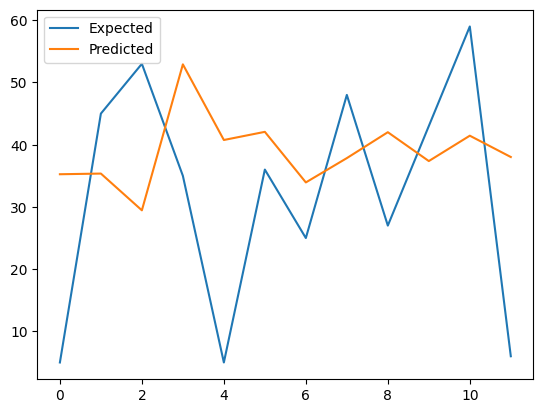

In [129]:
mae, y, yhat = walk_forward_validation(data,12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [130]:
from sklearn.metrics import mean_squared_error
import numpy as np

# function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# calculate MAPE
mape = mean_absolute_percentage_error(y, yhat)
print('MAPE: %.3f' % mape)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y, yhat))
print('RMSE: %.3f' % rmse)


MAPE: 178.590
RMSE: 20.356


In [133]:
values_pm25

array([[5],
       [64],
       [39],
       ...,
       [43],
       [59],
       [6]], dtype=object)

In [134]:
train = series_to_supervised(values_pm25, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=500)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values_pm25[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [25 48 27 43 59 6], Predicted: 45.406
